# Clone code and download weights

In [1]:
# clone model
!git clone https://github.com/richarduuz/Research_Project

Cloning into 'Research_Project'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (331/331), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 331 (delta 97), reused 264 (delta 56), pack-reused 0
Receiving objects: 100% (331/331), 14.55 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [2]:
# download weights
%cd /content/Research_Project/ModelC/face_modules/
!gdown https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp
%cd /content/Research_Project/ModelC/saved_models/
!gdown https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9

/content/Research_Project/ModelC/face_modules
Downloading...
From: https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp
To: /content/Research_Project/ModelC/face_modules/model_ir_se50.pth
175MB [00:12, 14.1MB/s]
/content/Research_Project/ModelC/saved_models
Downloading...
From: https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9
To: /content/Research_Project/ModelC/saved_models/G_latest.pth
737MB [00:07, 98.9MB/s]


# Load Model

In [3]:
%cd /content/Research_Project/ModelC/

/content/Research_Project/ModelC


In [0]:
import sys
import torch
sys.path.append('./face_modules/')
import torchvision.transforms as transforms
import torch.nn.functional as F
from face_modules.model import Backbone, Arcface, MobileFaceNet, Am_softmax, l2_norm
from network.AEI_Net import *
from face_modules.mtcnn import *
import cv2
import PIL.Image as Image
import numpy as np
import configparser

In [0]:
detector = MTCNN()
device = torch.device('cuda')
G = AEI_Net(c_id=512)
G.eval()
G.load_state_dict(torch.load('./saved_models/G_latest.pth', map_location=torch.device('cpu')))
G = G.cuda()

arcface = Backbone(50, 0.6, 'ir_se').to(device)
arcface.eval()
arcface.load_state_dict(torch.load('./face_modules/model_ir_se50.pth', map_location=device), strict=False)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Image Inference

## Upload source image

In [21]:
from google.colab import files
source_img = files.upload()
source_img_name = list(source_img.keys())[0]


Saving 00000000.jpg to 00000000 (2).jpg
00000000.jpg


## Upload target image

In [23]:
from google.colab import files
target_img = files.upload()
target_img_name = list(target_img.keys())[0]

Saving 00000001.jpg to 00000001.jpg


## Inference

./face_modules/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)


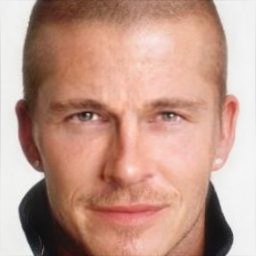

the result image has been saved


In [27]:
from google.colab.patches import cv2_imshow
Xs_raw = cv2.imread(source_img_name)
try:
    Xs = detector.align(Image.fromarray(Xs_raw[:, :, ::-1]), crop_size=(256, 256))
except Exception as e:
    print('the source image is wrong, please change the image')
Xs_raw = np.array(Xs)[:, :, ::-1]
Xs = test_transform(Xs)
Xs = Xs.unsqueeze(0).cuda()

with torch.no_grad():
    embeds = arcface(F.interpolate(Xs[:, :, 19:237, 19:237], (112, 112), mode='bilinear', align_corners=True))

Xt_raw = cv2.imread(target_img_name)
try:
    Xt, trans_inv = detector.align(Image.fromarray(Xt_raw[:, :, ::-1]), crop_size=(256, 256), return_trans_inv=True)
except Exception as e:
    print('the target image is wrong, please change the image')
Xt_raw = Xt_raw.astype(np.float)/255.0
Xt = test_transform(Xt)
Xt = Xt.unsqueeze(0).cuda()

mask = np.zeros([256, 256], dtype=np.float)
for i in range(256):
    for j in range(256):
        dist = np.sqrt((i-128)**2 + (j-128)**2)/128
        dist = np.minimum(dist, 1)
        mask[i, j] = 1-dist
mask = cv2.dilate(mask, None, iterations=20)

with torch.no_grad():
    Yt, _ = G(Xt, embeds)
    Yt = Yt.squeeze().detach().cpu().numpy().transpose([1, 2, 0])*0.5 + 0.5
    Yt = Yt[:, :, ::-1]
    Yt_trans_inv = cv2.warpAffine(Yt, trans_inv, (np.size(Xt_raw, 1), np.size(Xt_raw, 0)), borderValue=(0, 0, 0))
    mask_ = cv2.warpAffine(mask,trans_inv, (np.size(Xt_raw, 1), np.size(Xt_raw, 0)), borderValue=(0, 0, 0))
    mask_ = np.expand_dims(mask_, 2)
    Yt_trans_inv = mask_*Yt_trans_inv + (1-mask_)*Xt_raw
    cv2_imshow(Yt_trans_inv*255)
    cv2.imwrite('./result.jpg',Yt_trans_inv*255)
    print("the result image has been saved")
